In [ ]:
#imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from collections import Counter
 
#sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.datasets import make_classification



#tensorflow
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

## Preparing data for ANN

In [ ]:
#loading the dataset we created 
df = pd.read_csv("covid_dataset.csv")
 
#remove filename column 
df.drop(["filename"], axis=1, inplace=True)
df = df[df['label'] != 'unknown']

In [ ]:
#mapping for the results 
map_dict = {"negative":0, "positive":1}
 
#mapping the values of the dict 
df['label'] = df['label'].map(map_dict)

In [ ]:
#labels
y = df['label'].to_numpy()
 
#rest of data
X = (df.iloc[:, :-1]).to_numpy()

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

#cc = ClusterCentroids(random_state=0)
#X_resampled, y_resampled = cc.fit_resample(X, y)

In [ ]:
#instantiate the Label Encoder 
le = LabelEncoder()
 
#fit and transform the encoder 
y_resampled = le.fit_transform(y_resampled)
 
#instantiate scaler 
stsc = StandardScaler()
 
#fit transform scaler 
X_resampled = stsc.fit_transform(X_resampled)
 
#separating the data 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.75)

#initialize callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#class weights
class_weight = {0: 1.,
                1: 3.}

print(X_train.shape)

(2926, 20)


## Building an ANN

In [ ]:
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
acc_per_fold=[]
loss_per_fold=[]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True,random_state=42)

# K-fold Cross Validation model evaluation
fold_no = 1


#initialize a sequential model 
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

  # Compile the model
    model.compile(optimizer='adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

    print('-----------------------')

    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=128,
              epochs=50,
              validation_data=(X_test, y_test),
              callbacks=[early_stopping, mc]
              )

  # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

-----------------------
Training for fold 1 ...
Epoch 1/50
28/28 [==============================] - 1s 10ms/step - loss: 0.6911 - accuracy: 0.5533 - val_loss: 0.6905 - val_accuracy: 0.5082

Epoch 00001: val_accuracy improved from -inf to 0.50820, saving model to best_model.h5
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5303 - val_loss: 0.6677 - val_accuracy: 0.5768

Epoch 00002: val_accuracy improved from 0.50820 to 0.57684, saving model to best_model.h5
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.5832 - val_loss: 0.6563 - val_accuracy: 0.5891

Epoch 00003: val_accuracy improved from 0.57684 to 0.58914, saving model to best_model.h5
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.6081 - val_loss: 0.6455 - val_accuracy: 0.6209

Epoch 00004: val_accuracy improved from 0.58914 to 0.62090, saving model to best_model.h5
Epoch 5/50
28/28 [============

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.8731220960617065 - Accuracy: 48.33759665489197%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.7169853448867798 - Accuracy: 49.87212419509888%
------------------------------------------------------------------------
> Fold 3 - Loss: 2.112579584121704 - Accuracy: 49.743589758872986%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.7841007709503174 - Accuracy: 54.615384340286255%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9597108364105225 - Accuracy: 50.76923370361328%
------------------------------------------------------------------------
> Fold 6 - Loss: 2.2210614681243896 - Accuracy: 51.79487466812134%
-----------------------------------------------------------------------

## Evaluating ANN

In [ ]:
score = model.evaluate(X_test, 
                       y_test, 
                      batch_size=20,
                      steps=3)
print(X_test)
X_real = [[-530.6179199,	18.38093376,	-13.43567276,	13.50225735,	-8.69652462,	5.986907959,	-9.717094421,	1.417438745,	-4.564946175,	1.673386455,	0.156302944,	-4.657121658,	3.823266745,	-1.463427186,	0.626839399,	-5.152077675,	-2.040416241,	-2.548900604,	-0.977410972,	-0.468565971]]
y_real = model.predict_classes(X_real)


print(y_real)

3/3 [==============================] - 0s 3ms/step - loss: 0.3809 - accuracy: 0.9167
[[-4.01977004e-01  3.37002539e-01 -3.53674419e-01 ...  4.03372090e-01
   7.76395598e-01 -5.79829608e-01]
 [ 7.19145505e-01  7.94854491e-01 -1.75865132e+00 ... -1.55311902e+00
  -6.52866138e-01  1.08455498e+00]
 [ 1.28373798e+00 -6.38731627e-01 -2.52371083e+00 ... -2.91429559e-01
   1.34884591e+00  1.34383564e+00]
 ...
 [ 3.06803698e-01 -3.36883143e-01  1.05487327e-01 ... -3.78207755e-01
   2.00105438e-01  3.94094231e-01]
 [-2.93377138e-01 -8.12752515e-01 -1.86072154e-01 ...  1.09984790e+00
   4.13213341e-01  6.72868377e-01]
 [-7.89718320e-01 -9.31502341e-01  1.95229878e-03 ... -5.90833108e-01
   8.12945653e-01 -3.51428078e-01]]
[1]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    classNames = ['Negative','Positive']
    plt.title('COVID-19 Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.savefig("img/Fig6_Confusion_Matrix_50_epochs.png")
    plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


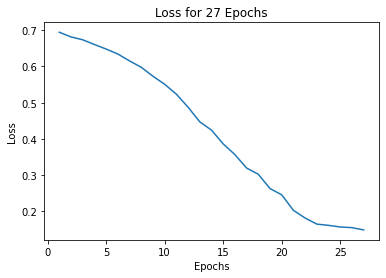

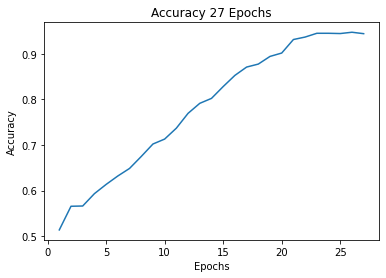

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



 **Confusion Matrix**



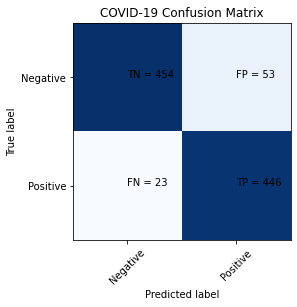


 **Classification Report**

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       507
           1       0.89      0.95      0.92       469

    accuracy                           0.92       976
   macro avg       0.92      0.92      0.92       976
weighted avg       0.92      0.92      0.92       976



In [ ]:
def plot_loss_accuracy(clf):
    loss_clf = clf.history['loss']
    acc_clf = clf.history['accuracy']
    epoch_range = list(range(1, 28))
 
    plt.figure()
    plt.plot(epoch_range, loss_clf)
    plt.title(f"Loss for {len(epoch_range)} Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig("Fig4_Loss_Per_50_Epochs.png")
 
 
    plt.figure()
    plt.plot(epoch_range, acc_clf)
    plt.title(f"Accuracy {len(epoch_range)} Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig("Fig5_Accuracy_per_50_epochs.png")
    plt.show()
    
    y_pred = model.predict_classes(X_test)
    print("\n **Confusion Matrix**\n")
    #print(confusion_matrix(y_test, y_pred))
    y_pred = model.predict_classes(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    classNames = ['Negative','Positive']
    plt.title('COVID-19 Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.savefig("Fig6_Confusion_Matrix_50_epochs.png")
    plt.show()
    print("\n **Classification Report**\n")
    print(classification_report(y_test, y_pred))
 
plot_loss_accuracy(history)

In [ ]:
model = tf.keras.models.load_model('best_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('covid.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6mtvocl8/assets


INFO:tensorflow:Assets written to: /tmp/tmp6mtvocl8/assets


In [ ]:
from google.colab import files

files.download('covid.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>